This notebook contains the workflow for processing iMet-XQ2 data from the profiling drone flights during the NSF BACS-I and BACS-II campaigns. 

Last edited: 12 November 2025

The workflow consists of three steps:
1. Read manual flight logs from BACS and select only the profiling drone flights.
2. Identify each of the ascending/descending flight segments from manual flight logs and iMet-XQ2 GPS data.
3. Quality control of iMet-XQ2 meteorological data, which is then written out as a series of netcdf files.

Inputs:
1. BACS drone logs (xlsx)
2. raw iMet-XQ2 data (csv)

Outputs:
1. BACS drone met profile data (netcdf)

For more details about the output files, see the documentation in 'README_BACS_Drone_Met_Profile.pdf'.

For questions, contact: Gabrielle Leung (gabrielle.leung@colostate.edu).

# Imports and Paths

## Shared Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import itertools
import glob
import xarray as xr
import metpy.calc as mpcalc
import metpy.units as units

## Plotting Parameters

In [2]:
# Bee's default plotting parameters
# These are not strictly necessary for the rest of the code.

from palettable.cartocolors.qualitative import Prism_8

prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = "#303039"
style = "/Users/gleung/OneDrive/06_Resources/06.03_matplotlib_styles/bee-paperlight.mplstyle"
plt.style.use(style)

col = [green, blue, purple]

## Define Paths

In [3]:
# defining paths
# If you are rerunning/reprocessing these data, you will need to change these to your local machine.

dataPath = "/Users/gleung/Downloads/bacs-drone-qc/"
figPath = (
    "/Users/gleung/Downloads/bacs-drone-qc/figures/"
)

## Shared Functions

In [4]:
drone_log_cols = [
    "flight_id",
    "iop_date_local",
    "iop",
    "drone_name",
    "flight_number_of_day",
    "nominal_altitude",
    "takeoff_time_local",
    "landing_time_local",
    "takeoff_time_utc",
    "landing_time_utc",
    "sensor_aspirated",
    "sensor_unaspirated",
]

In [5]:
imet_raw_data_cols = [
    "XQ-iMet-XQ Pressure",
    "XQ-iMet-XQ Air Temperature",
    "XQ-iMet-XQ Humidity",
    "XQ-iMet-XQ Humidity Temp",
    "XQ-iMet-XQ Date",
    "XQ-iMet-XQ Time",
    "XQ-iMet-XQ Longitude",
    "XQ-iMet-XQ Latitude",
    "XQ-iMet-XQ Altitude",
    "XQ-iMet-XQ Sat Count",
]

imet_data_cols = [
    "pressure",
    "temperature",
    "rh",
    "temperature_from_rh_sensor",
    "date",
    "time",
    "longitude",
    "latitude",
    "altitude_msl",
    "satellite_count",
]

In [ ]:
def clean_imet_data(
    path, imetCols=imet_raw_data_cols, imetnewCols=imet_data_cols
):
    # this function reads the data from the raw iMet files and cleans it up

    df = pd.read_csv(path, parse_dates=True)
    df = df[imetCols]
    df.columns = imetnewCols

    # iMet gives bad dates when GPS is not working, so get rid of those
    df = df[(df.date.str[:4] == "2023") | (df.date.str[:4] == "2022")]
    df = df[df.date.str[8:10] != "00"]

    # only want to use data when GPS has at least four satellites in view
    df = df[df.satellite_count >= 4]

    df["datetime_utc"] = pd.to_datetime(df.date + " " + df.time)
    df["datetime_local"] = df.datetime_utc - dt.timedelta(hours=6)

    return df

In [7]:
def split_consecutive_groups(lst):
    # this is a function to split list into groups of consecutive repeated values
    return [list(group) for key, group in itertools.groupby(lst)]

# Manual drone logs

In [42]:
# First, we need to standardize and concatenate the drone flight logs from BACS-I and BACS-II.

logs = []

for ver in ["bacs-i", "bacs-ii"]:
    # This is the  manual flight log
    log = pd.read_excel(f"{dataPath}/{ver}-log.xlsx", parse_dates=True)

    # renaming columns in manual flight log
    log = log.rename(
        columns={
            "Date ": "iop_date_local",
            "Drone": "drone_name",
            "IOP": "iop",
            "Flight Number": "flight_number_of_day",
            "Drone Altitude (m)": "nominal_altitude",
            "Takeoff TIme": "takeoff_time_local",
            "Landing Time": "landing_time_local",
            "iMet (Aspirated)": "sensor_aspirated",
            "iMet (Unaspirated) Name": "sensor_unaspirated",
        }
    )

    # Delete the other variables in the drone log, these are notes and not needed for the data upload
    log = log[[c for c in drone_log_cols if c in log.columns]]

    # select only the profiling flights
    log = log[
        (log.drone_name.str.lower() == "pj")
        | (log.nominal_altitude.astype("str").str.lower().str.contains("prof"))
    ]

    # exclude 2 flights that were marked as "bad" -- aborted flights because of issues with SASS drone
    log = log[~((log.nominal_altitude.astype("str").str).contains("bad"))]

    # get takeoff/landing times in standard format
    for var in ["takeoff_time_local", "landing_time_local"]:
        log[var] = [
            dt.datetime.combine(d.date(), t)
            for d, t in zip(log.iop_date_local, log[var])
        ]

        # all the flights were done in late morning to evening period local time,
        # so just convert everything to 24-hr time appropriately
        log.loc[log[~log[var].dt.hour.isin([10, 11, 12])].index, var] = log[
            ~log[var].dt.hour.isin([10, 11, 12])
        ][var] + dt.timedelta(hours=12)

        # convert local time to UTC
        log[f"{var.rstrip('_local')}_utc"] = log[var] + dt.timedelta(hours=6)

    # print out how many individual flights were in each campaign
    print(
        ver,
        len(
            log.groupby(["iop", "flight_number_of_day"])
            .drone_name.count()
            .index
        ),
    )

    logs.append(log)

logs = pd.concat(logs).reset_index(drop=True)

# We are missing data from last day (TOFIX)
logs = logs[logs.iop < 28]

# standardize drone names (this doesn't matter, just for my sanity)
logs["drone_name"] = logs.drone_name.replace({"Altocumulus": "Ac", "PJ": "Pj"})

print(
    "Total number of profiling flights: ",
    len(logs.groupby(["iop", "flight_number_of_day"]
                     ).drone_name.count().index),
)

bacs-i 13
bacs-ii 53
Total number of profiling flights:  64


In [43]:
# Want to give each flight over the whole campaign a unique flight ID from 01 to 99

flts = (
    logs.groupby(["iop", "flight_number_of_day"])
    .first()[["iop_date_local"]]
    .reset_index()
)
flts["flight_id"] = np.arange(1, len(flts) + 1).astype("str")
flts["flight_id"] = flts.flight_id.str.zfill(2)

print(flts)

logs = logs.merge(
    flts[["flight_id", "iop_date_local", "flight_number_of_day"]]
)[drone_log_cols]


# save this temporary flight log with takeoff and landing times
logs.to_csv(f"{dataPath}/profile_manual_flightlog.csv")

    iop  flight_number_of_day iop_date_local flight_id
0     5                     2     2022-05-31        01
1     5                     3     2022-05-31        02
2     9                     1     2022-06-07        03
3     9                     2     2022-06-07        04
4    10                     1     2022-06-09        05
..  ...                   ...            ...       ...
59   26                     4     2023-06-17        60
60   26                     5     2023-06-17        61
61   26                     6     2023-06-17        62
62   27                     1     2023-06-21        63
63   27                     2     2023-06-21        64

[64 rows x 4 columns]


## Initial count before screening for profiles

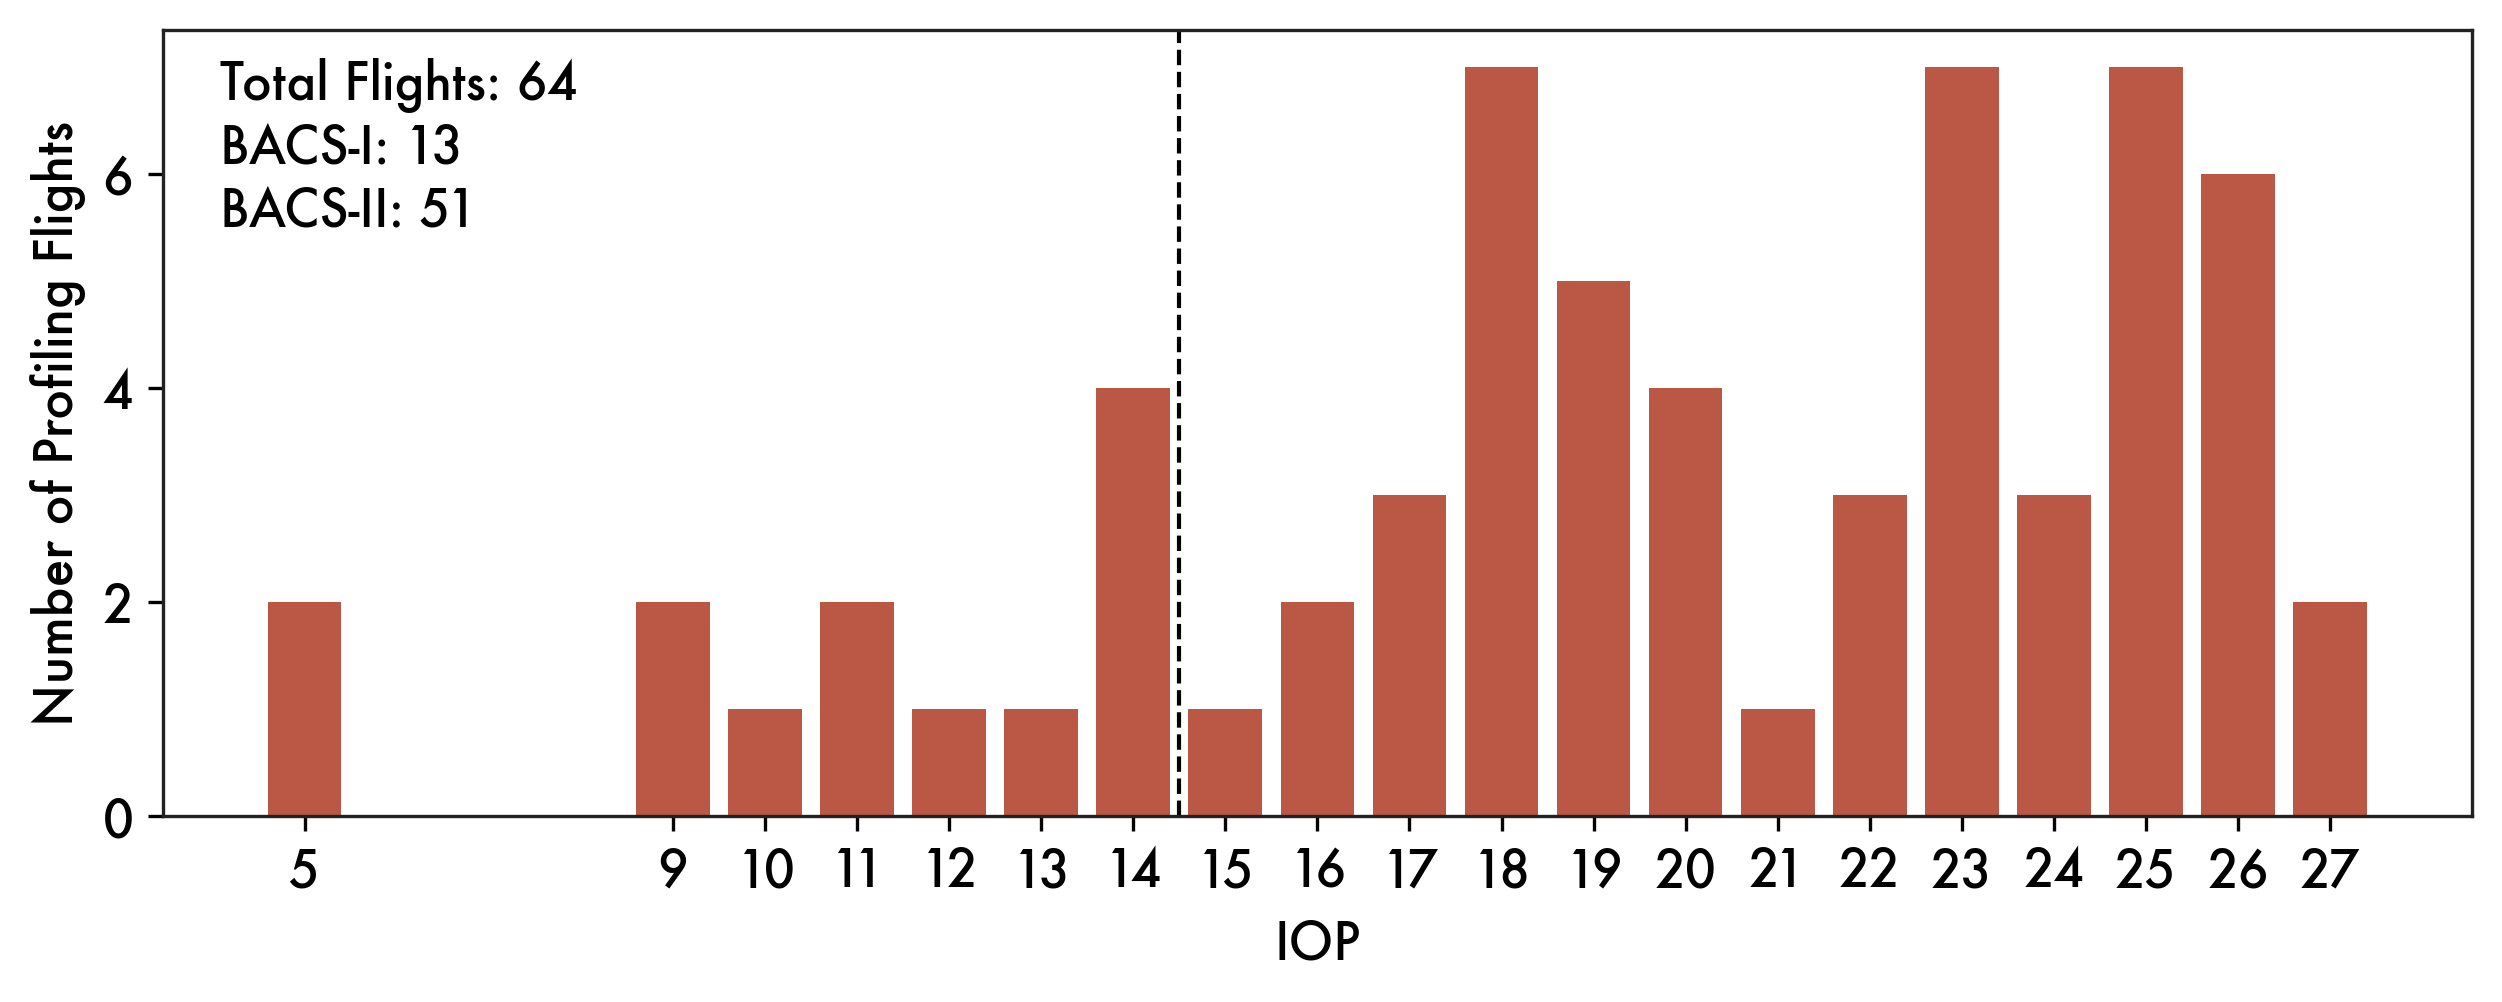

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8.5, 3.5))

ax.bar(logs.iop.unique(), logs.groupby("iop").flight_id.nunique())
ax.set_xlabel("IOP")
ax.set_ylabel("Number of Profiling Flights")
ax.axvline(14.5, lw=1, zorder=0, ls="--")
ax.set_xticks(logs.iop.unique())

plt.text(
    0.025,
    0.75,
    f"Total Flights: {len(logs.flight_id.unique())}\nBACS-I: {len(logs[logs.iop_date_local.dt.year == 2022].flight_id.unique())}\nBACS-II: {len(logs[logs.iop_date_local.dt.year == 2023].flight_id.unique())}",
    transform=ax.transAxes,
)

plt.show()
plt.close("all")

# Profiling drone logs

We want to create a log of the start and end time of each profile.

In [8]:
logs = pd.read_csv(
    f"{dataPath}/profile_manual_flightlog.csv",
    index_col=0,
    parse_dates=[
        "takeoff_time_utc",
        "landing_time_utc",
        "takeoff_time_local",
        "landing_time_local",
        "iop_date_local",
    ],
)
logs["flight_id"] = logs.flight_id.astype("str").str.zfill(2)

In [9]:
def assign_ascent_descent_flags(df, t_res=15, t_min=30, d_min=60):
    """

    Keyword Arguments:
        t_res -- averaging resolution (default: {15})
        t_min -- minimum time extent of profile to be included (default: {30})
        d_min -- minimum vertical extent of profile to be included (default: {100})

    """
    df["ascent_rate"] = df.altitude_msl.diff()
    df["ascent_rate_mean"] = df.ascent_rate.rolling(
        t_res, center=True, min_periods=5
    ).mean()
    df["ascent_rate_std"] = df.ascent_rate.rolling(
        t_res, center=True, min_periods=5
    ).std()

    # assign ascent/descent as periods of relatively consistent ascent/descent rate going up or down, respectively
    df["ascent_flag"] = (df.ascent_rate_mean >= 0.5) & (
        df.ascent_rate_std <= 1.5
    )
    df["descent_flag"] = (df.ascent_rate_mean <= -0.5) & (
        df.ascent_rate_std <= 1.5
    )

    # check if any period fulfills the ascent/descent criteria
    if len(df[(df.ascent_flag == 1) | (df.descent_flag == 1)]) > 10:

        # find groups where altitude flag is consecutive 1 or 0
        grps = split_consecutive_groups(df["ascent_flag"])
        lens = np.array([len(l) for l in grps])
        cumlen = lens.cumsum()

        for i, g in enumerate(grps[:-1]):
            if g[0]:  # if ascending
                # when the next gap in ascent flag is < minimum profile time/2, just combine it
                if lens[i + 1] <= t_min // 2:
                    df.loc[cumlen[i]: cumlen[i + 1] - 1, "ascent_flag"] = True

        # find groups where altitude flag is consecutive 1 or 0
        grps = split_consecutive_groups(df["ascent_flag"])
        lens = np.array([len(l) for l in grps])
        cumlen = lens.cumsum()

        for i, g in enumerate(grps):
            if g[0]:
                range = (
                    df.loc[cumlen[i - 1]: cumlen[i] - 1]["altitude_msl"].max()
                    - df.loc[cumlen[i - 1]: cumlen[i] - 1][
                        "altitude_msl"
                    ].min()
                )
                # impose criteria that profiles have to be at least t_min seconds long and have to span an altitude of at least d_min
                # to get rid of stubs
                if (lens[i] < t_min) | (range < d_min):
                    if cumlen[i - 1] > cumlen[i]:
                        df.loc[0: cumlen[i] - 1, "ascent_flag"] = False
                    else:
                        df.loc[cumlen[i - 1]: cumlen[i] - 1, "ascent_flag"] = (
                            False
                        )

        # find groups where altitude flag is consecutive 1 or 0
        grps = split_consecutive_groups(df["descent_flag"])
        lens = np.array([len(l) for l in grps])
        cumlen = lens.cumsum()

        for i, g in enumerate(grps[:-1]):
            if g[0]:  # if descending
                # when the next gap in ascent flag is < minimum profile time/2, just combine it
                if lens[i + 1] <= t_min // 2:
                    df.loc[cumlen[i]: cumlen[i + 1] - 1, "descent_flag"] = True

        # find groups where altitude flag is consecutive 1 or 0
        grps = split_consecutive_groups(df["descent_flag"])
        lens = np.array([len(l) for l in grps])
        cumlen = lens.cumsum()

        for i, g in enumerate(grps):
            if g[0]:
                range = (
                    df.loc[cumlen[i - 1]: cumlen[i] - 1]["altitude_msl"].max()
                    - df.loc[cumlen[i - 1]: cumlen[i] - 1][
                        "altitude_msl"
                    ].min()
                )

                # impose criteria that profiles have to be at least t_min seconds long and have to span an altitude of at least d_min
                # to get rid of stubs
                if (lens[i] < t_min) | (range < d_min):
                    if cumlen[i - 1] > cumlen[i]:
                        df.loc[0: cumlen[i] - 1, "descent_flag"] = False
                    else:
                        df.loc[
                            cumlen[i - 1]: cumlen[i] - 1, "descent_flag"
                        ] = False

        return df
    else:
        return pd.DataFrame(columns=df.columns)

In [10]:
def plot_profile_determination(df, log, sensor):
    # create plots to sanity check whether correct timeperiod is being flagged as in stack

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 9))

    for ax, var, title, units in zip(
        axes,
        ["temperature", "altitude_msl", "ascent_rate_mean"],
        ["(a) Temperature", "(b) Altitude", "(c) Ascent Rate"],
        ["$^\circ$C", "m (ASL)", "m s$^{-1}$"],
    ):
        ax.plot(df.datetime_local, df[var], color="black")
        ax.set_title(title)
        ax.set_ylabel(units)

        if var == "ascent_rate_mean":
            # on secondary axis, plot the standard deviation over given time period

            std_ax = ax.twinx()

            std_ax.plot(df.datetime_local,
                        df[f"ascent_rate_std"], color="gray")
            std_ax.axhline(1.5, ls="--", color="gray", lw=1, zorder=0)

            std_ax.set_ylabel("Standard Deviation", color="gray")
            std_ax.spines["right"].set_edgecolor("gray")
            std_ax.tick_params(axis="y", colors="gray")

            ax.axhline(0.5, color=red, lw=1, zorder=0)
            ax.axhline(-0.5, color=blue, lw=1, zorder=0)

        if var == "altitude_msl":
            ax.scatter(
                df[df.ascent_flag == 1].datetime_local,
                df[df.ascent_flag == 1].altitude_msl,
                marker="o",
                s=1,
                label="At-Altitude",
                zorder=10,
                color=red,
            )

            ax.scatter(
                df[df.descent_flag == 1].datetime_local,
                df[df.descent_flag == 1].altitude_msl,
                marker="o",
                s=1,
                label="At-Altitude",
                zorder=10,
                color=blue,
            )

    n_ascents = split_consecutive_groups(df.ascent_flag)
    n_ascents = len([n for n in n_ascents if n[0]])

    n_descents = split_consecutive_groups(df.descent_flag)
    n_descents = len([n for n in n_descents if n[0]])

    if (n_ascents > 0) | (n_descents > 0):

        for ax in axes:
            ax.axvline(
                df[
                    (df.ascent_flag == 1) | (df.descent_flag == 1)
                ].datetime_local.iloc[0]
            )
            ax.axvline(
                df[
                    (df.ascent_flag == 1) | (df.descent_flag == 1)
                ].datetime_local.iloc[-1]
            )

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[-1].set_xlabel("Time (Local/MDT)")

    plt.suptitle(
        f"IOP{log.iop}, {log.iop_date_local.strftime('%Y-%m-%d')}\nFlight {log.flight_id}\nDuration {len(df[(df.ascent_flag == 1) | (df.descent_flag == 1)])/60:.1f} mins\n{n_ascents} Ascending, {n_descents} Descending",
        fontsize=20,
        ha="center",
        va="top",
    )

    plt.tight_layout()

    plt.savefig(
        f"{figPath}/profile_identification/sf{str(log.flight_id).zfill(2)}_{sensor}.png"
    )
    plt.close("all")

<>:10: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:10: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_38959/2838530322.py:10: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
  ["$^\circ$C", "m (ASL)", "m s$^{-1}$"],


In [11]:
def identify_profile_segments(df, log, sensor, plot=True):
    df = df.reset_index(drop=True)

    df = assign_ascent_descent_flags(df)

    df = df.dropna()

    if plot:
        plot_profile_determination(df, log, sensor)

    if len(df[(df.ascent_flag) | (df.descent_flag)]) > 0:

        return (df.datetime_utc.min(), df.datetime_utc.max())
    else:
        return (np.nan, np.nan)

In [33]:
# going through our manual flight logs to find profile times
prof_log = pd.DataFrame(
    index=logs.index,
    columns=[
        "flight_id",
        "iop",
        "iop_date_local",
        "sensor_aspirated",
        "sensor_unaspirated",
        "aspirated_start_time_utc",
        "aspirated_end_time_utc",
        "unaspirated_start_time_utc",
        "unaspirated_end_time_utc",
    ],
)

# loop over each individual flight
for l, log in logs.iterrows():

    prof_log.loc[
        l,
        [
            "flight_id",
            "iop",
            "iop_date_local",
            "sensor_aspirated",
            "sensor_unaspirated",
        ],
    ] = [
        log.flight_id,
        log.iop,
        log.iop_date_local,
        log.sensor_aspirated,
        log.sensor_unaspirated,
    ]

    for sensor in ["aspirated", "unaspirated"]:
        if not (pd.isnull(log[f"sensor_{sensor}"])):
            # format of iMet path for a given day
            imetPath = f"{dataPath}/raw_data/{log[f'sensor_{sensor}']}-{
                log.iop_date_local.strftime('%Y%m%d')}*.csv"

            # read in raw XQ2 data from iMet CSVs
            # allow for multiple files in case there was more than one file for that day
            imetData = pd.concat(
                [clean_imet_data(path) for path in glob.glob(imetPath)]
            ).sort_values("datetime_utc")

            # just subset the times which occur within this flight
            imetData = imetData[
                (
                    imetData.datetime_utc
                    >= log.takeoff_time_utc - dt.timedelta(minutes=5)
                )
                & (
                    imetData.datetime_utc
                    <= log.landing_time_utc + dt.timedelta(minutes=5)
                )
            ]

            start_time_utc, end_time_utc = identify_profile_segments(
                imetData, log, sensor, plot=True
            )

            prof_log.loc[l, f"{sensor}_start_time_utc"] = start_time_utc
            prof_log.loc[l, f"{sensor}_end_time_utc"] = end_time_utc

for sensor in ["aspirated", "unaspirated"]:
    prof_log[f"{sensor}_profile_duration"] = (
        pd.to_datetime(prof_log[f"{sensor}_end_time_utc"])
        - pd.to_datetime(prof_log[f"{sensor}_start_time_utc"])
    ) / dt.timedelta(minutes=1)

# remove any which have no iMet data
print(len(prof_log))
prof_log = prof_log[
    ~(
        (prof_log.aspirated_start_time_utc.isnull())
        & (prof_log.aspirated_end_time_utc.isnull())
        & (prof_log.unaspirated_start_time_utc.isnull())
        & (prof_log.unaspirated_end_time_utc.isnull())
    )
].reset_index()
print(len(prof_log))

# going to renumber and rename the flight IDs to match
prof_log["flight_id"] = (prof_log.index + 1).astype("str").str.zfill(2)


# finally, save the final profile log
prof_log.to_csv(f"{dataPath}/profile_final_flightlog.csv")

64
62


In [62]:
prof_log["iop_date_local"] = pd.to_datetime(prof_log.iop_date_local)

AttributeError: Can only use .dt accessor with datetimelike values

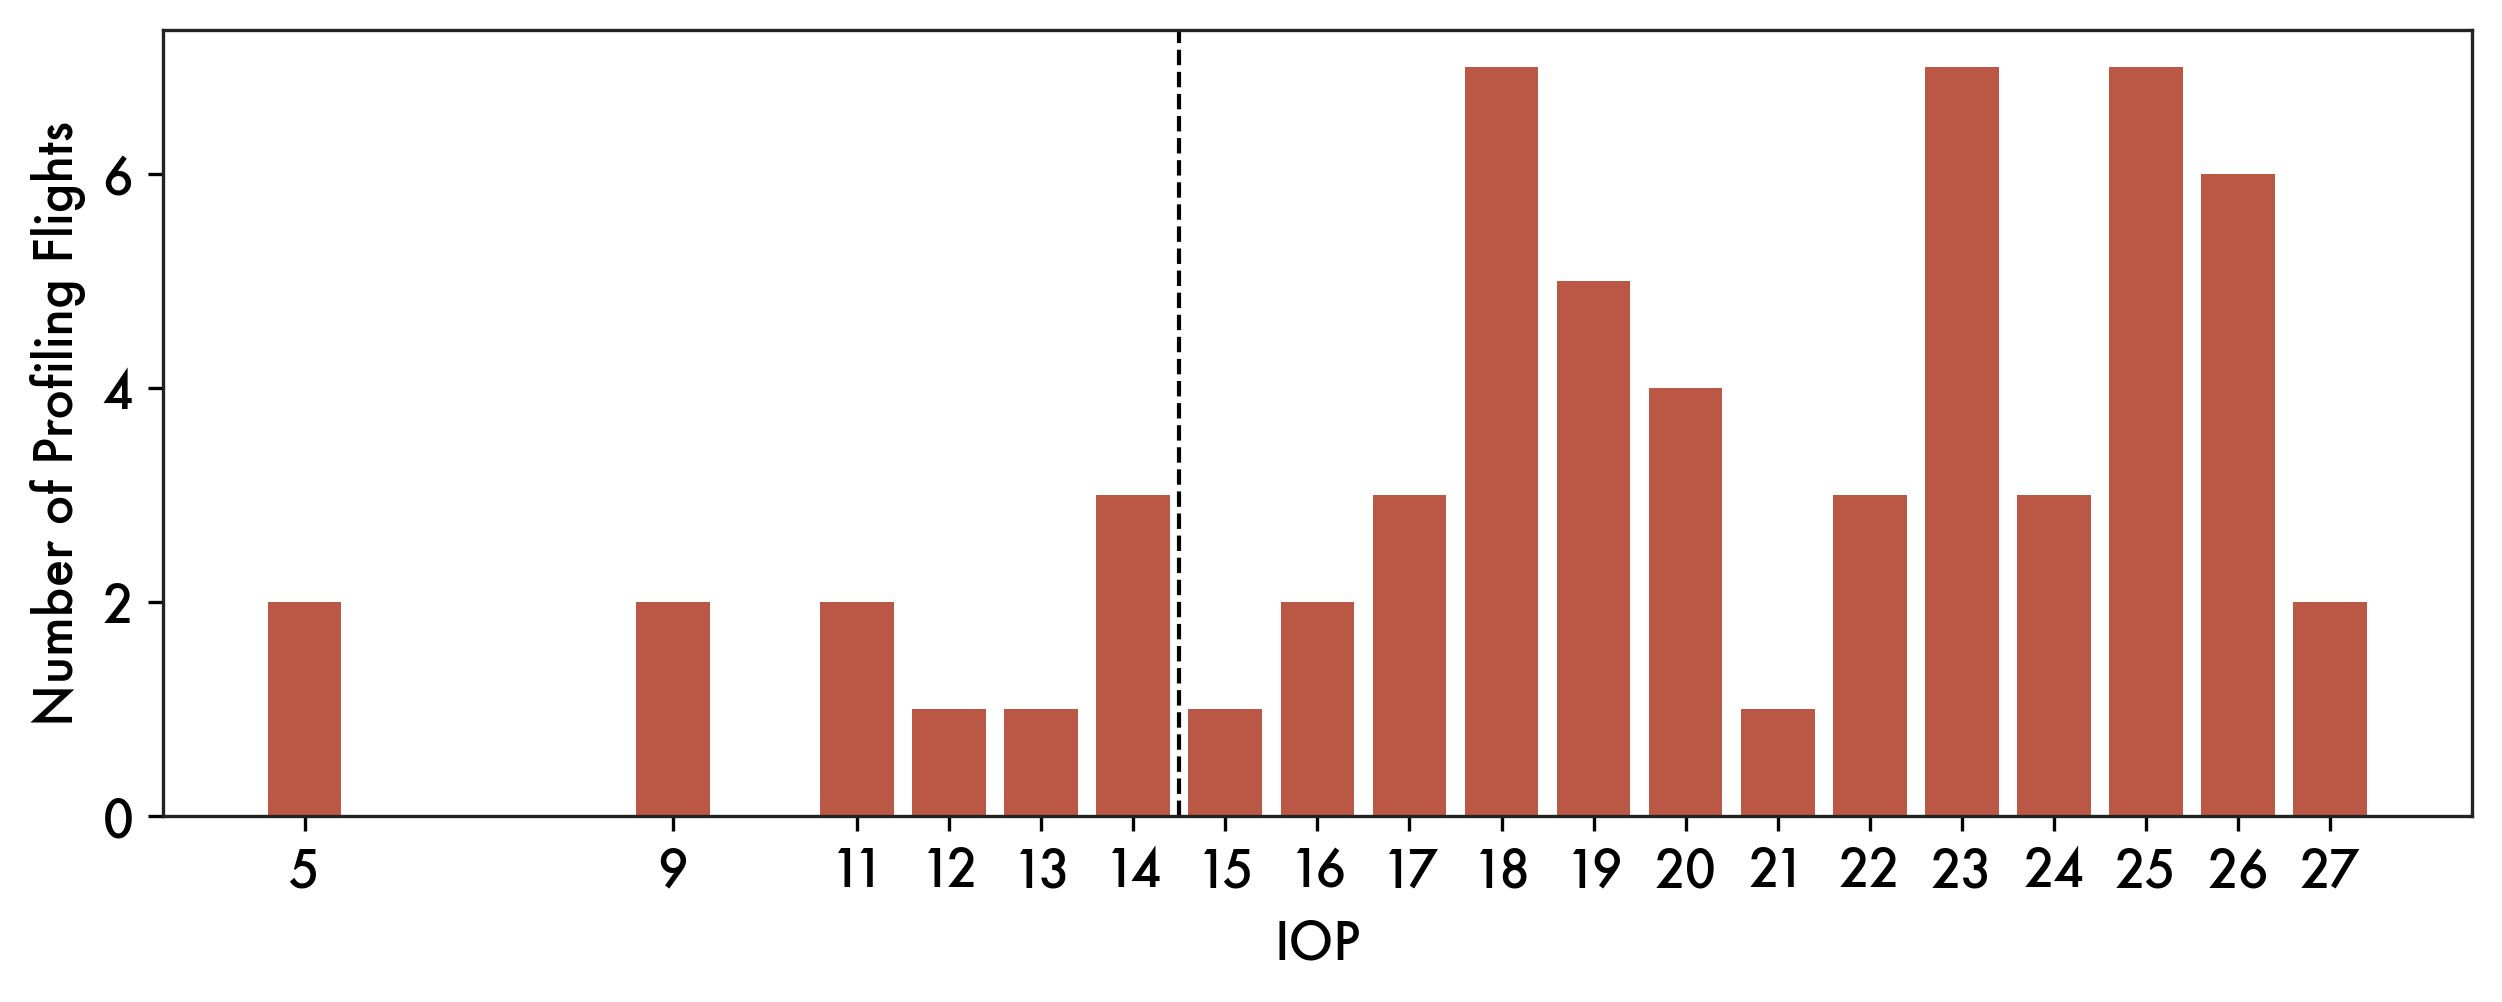

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8.5, 3.5))

ax.bar(prof_log.iop.unique(), prof_log.groupby("iop").flight_id.nunique())
ax.set_xlabel("IOP")
ax.set_ylabel("Number of Profiling Flights")
ax.axvline(14.5, lw=1, zorder=0, ls="--")
ax.set_xticks(prof_log.iop.unique().astype(int))

plt.text(
    0.025,
    0.75,
    f"Total Flights: {len(prof_log.flight_id.unique())}\nBACS-I: {len(prof_log[prof_log.iop_date_local.dt.year == 2022].flight_id.unique())}\nBACS-II: {len(prof_log[prof_log.iop_date_local.dt.year == 2023].flight_id.unique())}",
    transform=ax.transAxes,
)

plt.show()
plt.close("all")

# Process each flight

In [12]:
prof_log = pd.read_csv(
    f"{dataPath}/profile_final_flightlog.csv", parse_dates=True
)
prof_log["iop_date_local"] = pd.to_datetime(prof_log["iop_date_local"])

print(prof_log)

    Unnamed: 0  index  flight_id  iop iop_date_local sensor_aspirated  \
0            0      0          1    5     2022-05-31              X02   
1            1      1          2    5     2022-05-31              X02   
2            2      2          3    9     2022-06-07              X02   
3            3      3          4    9     2022-06-07              X02   
4            4      5          5   11     2022-06-11              X04   
..         ...    ...        ...  ...            ...              ...   
57          57     59         58   26     2023-06-17              X10   
58          58     60         59   26     2023-06-17              X10   
59          59     61         60   26     2023-06-17              X10   
60          60     62         61   27     2023-06-21              X07   
61          61     63         62   27     2023-06-21              X07   

   sensor_unaspirated aspirated_start_time_utc aspirated_end_time_utc  \
0                 NaN      2022-05-31 18:07:01    

In [13]:
out_variables = [
    "datetime_local",
    "latitude",
    "longitude",
    "altitude_msl",
    "satellite_count",
    "pressure",
    "temperature",
    "rh",
    "temperature_from_rh_sensor",
    "ascent_flag",
    "descent_flag",
]

In [14]:
def calculate_rh_correction(ds):
    # iMet recommends a correction of the RH value using the temperature recorded by the RH sensor

    # in a few flights, RH is constantly at 100% the entire flight (IOP 23), which seems to be
    # a sensor issue. masking out all values where RH >= 100 initially

    ds["rh"] = xr.where(ds.rh < 100, ds.rh, np.nan)
    ds = ds.assign(
        rh=(
            ("sensor_type", "datetime_utc"),
            (
                ds.rh
                * (
                    mpcalc.saturation_vapor_pressure(
                        ds.temperature_from_rh_sensor * units.units("celsius")
                    )
                    / mpcalc.saturation_vapor_pressure(
                        ds.temperature * units.units("celsius")
                    )
                )
            ).values,
        )
    )

    ds = ds.drop_vars(["temperature_from_rh_sensor"])

    return ds


def add_metadata(ds):
    # add metadata
    ds["temperature"] = ds["temperature"].assign_attrs(
        {"units": "degCelsius", "long_name": "temperature"}
    )
    ds["rh"] = ds["rh"].assign_attrs(
        {
            "units": "%",
            "long_name": "relative humidity, corrected using temperature measured by RH sensor",
        }
    )
    ds["pressure"] = ds["pressure"].assign_attrs(
        {"units": "hPa", "long_name": "pressure"}
    )
    ds["latitude"] = ds["latitude"].assign_attrs(
        {"units": "degrees", "long_name": "latitude"}
    )
    ds["longitude"] = ds["longitude"].assign_attrs(
        {"units": "degrees", "long_name": "longitude"}
    )
    ds["altitude_msl"] = ds["altitude_msl"].assign_attrs(
        {"units": "meters", "long_name": "altitude in meters above sea level"}
    )
    ds["satellite_count"] = ds["satellite_count"].assign_attrs(
        {"long_name": "number of satellites available for XQ2 GPS"}
    )
    ds["datetime_local"] = ds["datetime_local"].assign_attrs(
        {"long_time": "local time (Mountain Daylight Time)"}
    )

    return ds


def add_qc_flags(ds):
    for var in ["temperature", "pressure", "rh"]:
        ds[f"{var}_qcflag"] = (~ds[var].isnull()).assign_attrs(
            {
                "long_name": f"QC flag for {var} data: 1 if data is good, 0 if data is bad and has been removed"
            }
        )

    return ds

In [ ]:
def merge_sensors(flight_log):
    # this takes the logs for one flight id and returns an xarray which merges all the sensors/altitudes

    merged_data = []

    for sensor in ["aspirated", "unaspirated"]:
        if flight_log[f"{sensor}_profile_duration"] > 0:
            imetPath = f"{dataPath}/raw_data/{flight_log[f'sensor_{sensor}']}-{
                flight_log.iop_date_local.strftime('%Y%m%d')}*.csv"

            # read in raw XQ2 data from iMet CSVs
            # allow for multiple files in case there was more than one file for that day
            imetData = pd.concat(
                [clean_imet_data(path) for path in glob.glob(imetPath)]
            ).sort_values("datetime_utc")

            # subset period within identified instack time from stack flight logs
            imetData = imetData[
                (
                    imetData.datetime_utc
                    >= flight_log[f"{sensor}_start_time_utc"]
                )
                & (
                    imetData.datetime_utc
                    <= flight_log[f"{sensor}_end_time_utc"]
                )
            ]

            imetData = assign_ascent_descent_flags(
                imetData.reset_index(drop=True)
            )
            imetData = imetData.groupby("datetime_utc").first()

            # converting these to xarray
            imetData = imetData[out_variables].to_xarray()
            imetData = imetData.assign_coords(
                {
                    "sensor_type": pd.Series([sensor]),
                }
            )

            merged_data.append(imetData)

    merged_data = xr.concat(merged_data, dim="sensor_type")
    merged_data = merged_data.assign_coords(
        datetime_local=[
            pd.to_datetime(t) - dt.timedelta(hours=6)
            for t in merged_data.datetime_utc.values
        ]
    )

    merged_data = merged_data.assign_coords(
        datetime_utc_str=merged_data.datetime_utc.dt.strftime(
            '%Y-%m-%d-%H%M%S')
    )

    return merged_data

In [16]:
def qc_rapid_fluctuations(ds, flight_log):
    fig, axess = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

    axes = axess.T[0]
    naxes = axess.T[1]

    out = []

    # loop over aspirated and unaspirated sensors separately
    for sensor, ls in zip(ds.sensor_type.values, ["-", "--"]):
        temp = ds.sel(sensor_type=sensor).copy()

        out_ = []

        # we do the QC separately for ascending and descending profiles (so that we aren't mixing profiles togehter when we take statistics of running means, etc.)
        for ver, color in zip(["ascent", "descent"], [red, blue]):
            p = temp.where(temp[f"{ver}_flag"])

            for ax, nax, var, accuracy in zip(
                axes, naxes, ["pressure", "temperature", "rh"], [1.5, 0.3, 5]
            ):

                # any points where the value fluctuates greater than 10 x accuracy
                # or 10 standard deviations away from the running median is likely erroneous
                # higher threshold than for the stacked flights since we do expect some change with changing alt

                p[f"{var}_qcflag"] = (
                    np.abs(
                        p[var]
                        - p[var]
                        .rolling(
                            datetime_utc=60 * 5, center=True, min_periods=1
                        )
                        .median()
                    )
                    < (10 * accuracy)
                ) & (
                    np.abs(
                        p[var]
                        - p[var]
                        .rolling(
                            datetime_utc=60 * 5, center=True, min_periods=1
                        )
                        .median()
                    )
                    < (
                        10
                        * p[var]
                        .rolling(
                            datetime_utc=60 * 5, center=True, min_periods=1
                        )
                        .std()
                    )
                )

                # pressure needs to be manually filtered in three flights where the pressure data is bad for a large portion of the flight (SF3, 4, 15)
                if (var == 'pressure'):

                    if flight_log.flight_id == 4:
                        p[f"{var}_qcflag"] = 0
                    elif flight_log.flight_id == 3:
                        p[f"{var}_qcflag"] = p[f"{var}_qcflag"] & (
                            p.datetime_utc > pd.to_datetime('2022-06-07 20:31:50'))
                    elif flight_log.flight_id == 15:
                        if sensor == 'aspirated':
                            p[f"{var}_qcflag"] = p[f"{var}_qcflag"] & (
                                p.datetime_utc > pd.to_datetime('2023-05-27 18:32'))

                elif var == 'rh':
                    if flight_log.flight_id == 15:
                        p[f"{var}_qcflag"] = 0

                ax.plot(p.datetime_local, p[var], ls=ls, color=color)

                p[var] = p[var].where(p[f"{var}_qcflag"])

                nax.plot(
                    p.datetime_local,
                    p[var],
                    ls=ls,
                    color=color,
                    label=f"{ver} {p.sensor_type.values}",
                )

                ax.set_title(f"{var}")
                nax.set_title(f"{var} after QC")

                ax.set_ylabel(ds[var].units)

            out_.append(p)

        out.append(xr.where(out_[0].ascent_flag.fillna(0), out_[0], out_[1]))

    out = xr.concat(out, dim="sensor_type")

    # for all variables, only keep data when either ascending or descending (removes extra time when drone is stationary at top/bottom of profile)
    for var in ["pressure", "temperature", "rh"]:
        out[f"{var}_qcflag"] = (out.ascent_flag == 1) | (out.descent_flag == 1)

    nax.legend(ncols=3)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.set_xlabel("Time (Local/MDT)")

    nax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    nax.set_xlabel("Time (Local/MDT)")

    plt.suptitle(
        f"{flight_log.iop_date_local.strftime('%Y-%m-%d')}, IOP{flight_log.iop}\nFlight {flight_log.flight_id}",
        fontsize=20,
    )

    plt.tight_layout()

    plt.savefig(
        f"{figPath}/profile_qc/sf{str(flight_log.flight_id).zfill(2)}.png")

    plt.close("all")

    return out

In [17]:
for i, flight_log in prof_log.iterrows():
    imetData = merge_sensors(flight_log)
    imetData = calculate_rh_correction(imetData)
    imetData = add_metadata(imetData)
    imetData = add_qc_flags(imetData)
    imetData = qc_rapid_fluctuations(imetData, flight_log)

    # save file
    imetData.to_netcdf(
        f"{dataPath}/data_upload/profile/BACS-drone-met-profile_{flight_log.iop_date_local.strftime('%Y%m%d')}_IOP{str(flight_log.iop).zfill(2)}_F{str(flight_log.flight_id).zfill(2)}.nc"
    )

/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_38959/2672572461.py:44: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data = xr.concat(merged_data, dim="sensor_type")
/Users/gleung/miniforge3/envs/bacs/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gleung/miniforge3/envs/bacs/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gleung/miniforge3/envs/bacs/lib/py